In [62]:
import matplotlib.pyplot as plt
from matplotlib import animation
import random
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from pyod.models.knn import KNN

from keras.layers import Input, Dropout, Dense, LSTM,TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

%matplotlib inline

In [63]:
#load data
DroneData = pd.read_csv('./DroneData/SP Cup 2020/IMU_camera Drone Synchronized training dataset_normal behabiour_no abnormalities/_slash_mavros_slash_imu_slash_data.csv')
params = ['x','y','z','w','x.1','y.1','z.1','x.2','y.2','z.2']


In [64]:
def extract_normalization_params(DroneData, params = ['x','y','z','w','x.1','y.1','z.1','x.2','y.2','z.2']):
    """
    Extracts only the normal distribution z scores 
    of from the data
    input = Data, parameters
    """
    imuParamsData = DroneData.loc[:, params]
    mod = StandardScaler()
    mod.fit(imuParamsData)
    return mod

def normalize_test_data(Data, mod, params = ['x','y','z','w','x.1','y.1','z.1','x.2','y.2','z.2']):
    imuParamsData = Data[params]
    normImuData = mod.transform(imuParamsData)
    return normImuData

def find_theta_score(Data, pcamod):
    """
    Converts n dimensions to a lower dimensional score,
    for easier visualization
    
    theta_scorea = pca.transform(Data[['x','y','z','w']])
    
    pca.fit(Data[['x.1','y.1','z.1']])
    theta_scoreb = pca.transform(Data[['x.1','y.1','z.1']])
    
    pca.fit(Data[['x.2','y.2','z.2']])
    theta_scorec = pca.transform(Data[['x.2','y.2','z.2']])
    
    return np.array([theta_scorea, theta_scoreb, theta_scorec]).T[0]
    """
    theta = pcamod.transform(Data)

    return theta

def plot_anomalies_in_1D(z_score, anomalyPrediction):
    """
    plots anomalies (red) and 1D z score of the dataset
    """
    for i in range(len(z_score)):
        if anomalyPrediction[i] == True:
            plt.scatter(i,z_score[i],c = 'r')
    plt.plot(z_score)

def plot_anomalies_in_2D(z2_score, anomalyPrediction):
    """
    plots z1 and z2 as a scatter plot on x and y axes respectively,
    with anomalies as red points and normal instances as blue
    """
    anom = []
    noanom = []
    for i in range(len(z2_score.T)):
        if anomalyPrediction[i]:
            anom.append([z2_score[0][i],z2_score[1][i]])
        else:
            noanom.append([z2_score[0][i],z2_score[1][i]])
    noanom = np.array(noanom).T
    anom = np.array(anom).T
    plt.scatter(noanom[0],noanom[1] ,c = 'b',label = 'Normal Instance')
    plt.scatter(anom[0],anom[1],c = 'r',label = 'Anomaly')
    plt.legend()

In [66]:
#fit mean and std for normalization

mod = extract_normalization_params(DroneData)
mod.fit(DroneData[params])
trainData = mod.transform(DroneData[params])
pcamod = PCA(n_components=1)
pcamod.fit(trainData);


In [68]:
#import new test data here
testData1 = normalize_test_data(pd.concat([pd.read_csv('DroneData/SP Cup 2020/03_Dataset with 5 normal experiments_17Jan2020/2020-01-17-11-32-12/_slash_mavros_slash_imu_slash_data.csv'),
                                         pd.read_csv('DroneData/SP Cup 2020/03_Dataset with 5 normal experiments_17Jan2020/2020-01-17-11-32-49/_slash_mavros_slash_imu_slash_data.csv'),
                                          pd.read_csv('DroneData/SP Cup 2020/03_Dataset with 5 normal experiments_17Jan2020/2020-01-17-11-33-26/_slash_mavros_slash_imu_slash_data.csv'),
                                          pd.read_csv('DroneData/SP Cup 2020/03_Dataset with 5 normal experiments_17Jan2020/2020-01-17-11-34-08/_slash_mavros_slash_imu_slash_data.csv'),
                                          pd.read_csv('DroneData/SP Cup 2020/03_Dataset with 5 normal experiments_17Jan2020/2020-01-17-11-34-43/_slash_mavros_slash_imu_slash_data.csv')]), mod)

testData2 = normalize_test_data(pd.read_csv('DroneData/SP Cup 2020/04_Dataset with 5 abnormal experiments_17Jan2020/2020-01-17-11-37-25/_slash_mavros_slash_imu_slash_data.csv'), mod)
z_score1 = find_theta_score(testData1,pcamod)
z_score2 = find_theta_score(testData2,pcamod)

# define pca models for different n values
pcamod = PCA(n_components=2)
pcamod.fit(trainData)
z2_score = find_theta_score(np.concatenate((testData1, testData2)),pcamod)

#if not doing pca n=10
pcamod = PCA(n_components=10)
pcamod.fit(trainData)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

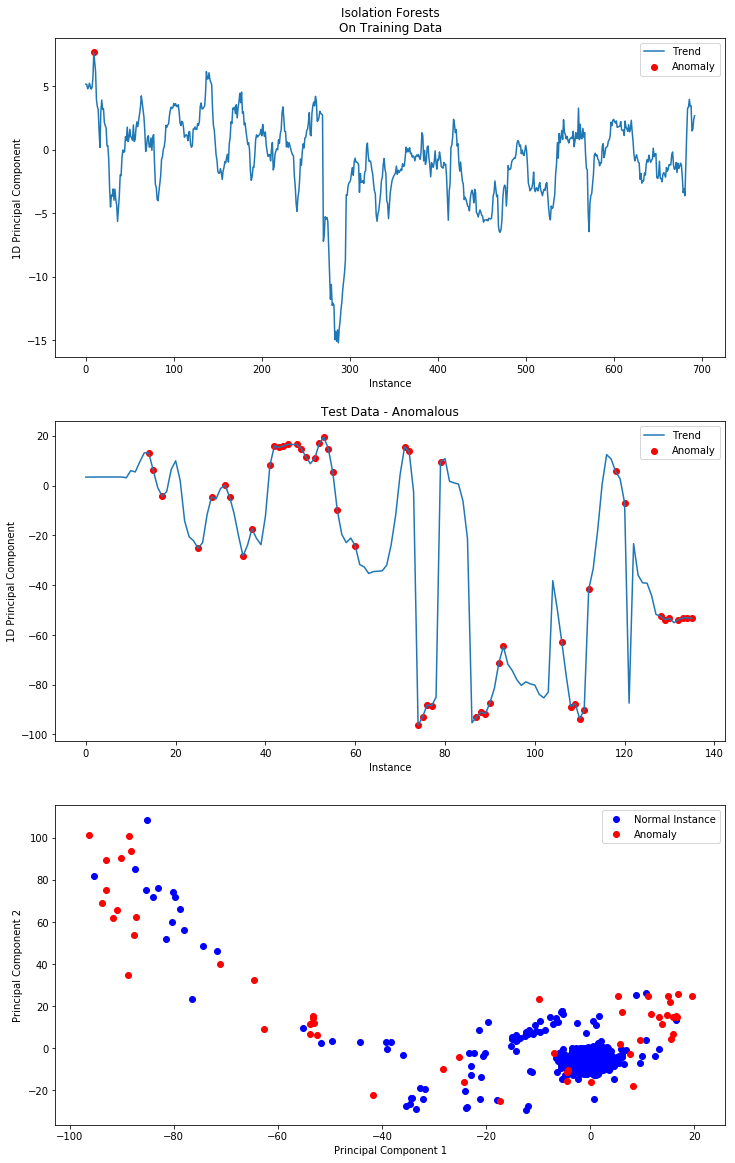

In [69]:
# using IsoFo

#add your algos in this very format pls

#isofo is statistical, so we need to specify contamination beforehand, 
#which may not be a good method since our problem is very sparse in nature

#fit isofo model

clf = IsolationForest(n_estimators=1000,contamination=0.00001, behaviour='new') #contamination parameter specifies the level of contamination in training data
clf.fit(find_theta_score(trainData,pcamod))
#    print(int(i/0.0001*100),end = '\r')

#predict anomalies
tempanomalyPrediction1 = clf.predict(find_theta_score(testData1,pcamod))
anomalyPrediction1 = tempanomalyPrediction1 == -1

tempanomalyPrediction2 = clf.predict(find_theta_score(testData2,pcamod))
anomalyPrediction2 = tempanomalyPrediction2 == -1


#plotting
plt.figure(figsize = (12,20))
ax1 = plt.subplot(3,1,1)
ax1.title.set_text('Isolation Forests\nOn Training Data')
ax1.set_xlabel('Instance')
ax1.set_ylabel('1D Principal Component')
plot_anomalies_in_1D(z_score1.T[0], anomalyPrediction1)

ax2 = plt.subplot(3,1,2)
ax2.title.set_text('Test Data - Anomalous')
ax2.set_xlabel('Instance')
ax2.set_ylabel('1D Principal Component')
plot_anomalies_in_1D(z_score2.T[0], anomalyPrediction2)


ax3 = plt.subplot(3,1,3)
ax3.set_xlabel('Principal Component 1')
ax3.set_ylabel('Principal Component 2')

plot_anomalies_in_2D(z2_score.T, np.concatenate((anomalyPrediction1, anomalyPrediction2)))
ax1.legend(['Trend','Anomaly'])
ax2.legend(['Trend','Anomaly'])

In [70]:
#left blank intentionally

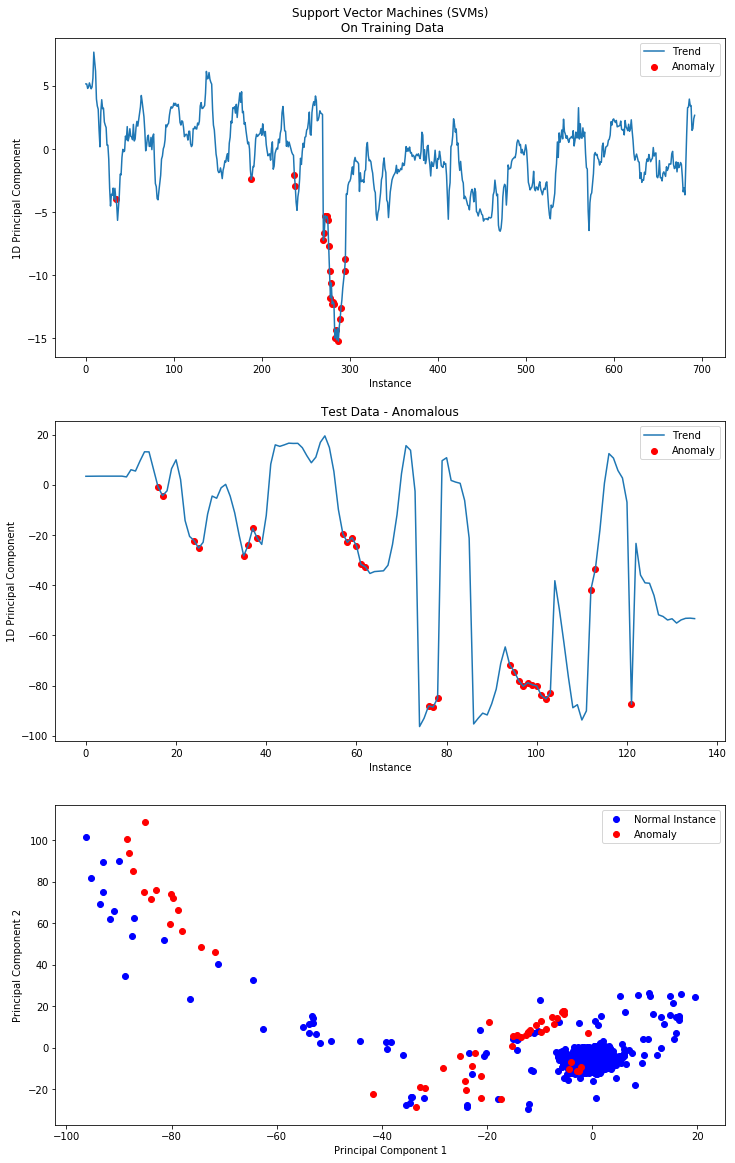

In [71]:
#using one class SVM


#fit model

oneclass = OneClassSVM(kernel='linear',nu = 0.9864317)
oneclass.fit(find_theta_score(trainData,pcamod))
#print(int((i-0.986431)/(0.986432-0.986431)*100),end = '\r')

#predict anomalies
tempanomalyPredictionSVM1 = oneclass.predict(find_theta_score(testData1,pcamod))
anomalyPredictionSVM1 = tempanomalyPredictionSVM1 == -1

tempanomalyPredictionSVM2 = oneclass.predict(find_theta_score(testData2,pcamod))
anomalyPredictionSVM2 = tempanomalyPredictionSVM2 == -1

plt.figure(figsize = (12,20))
ax1 = plt.subplot(3,1,1)

ax1.title.set_text('Support Vector Machines (SVMs)\n On Training Data')
ax1.set_xlabel('Instance')
ax1.set_ylabel('1D Principal Component')


plot_anomalies_in_1D(z_score1.T[0], anomalyPredictionSVM1)
ax2 = plt.subplot(3,1,2)
ax2.title.set_text('Test Data - Anomalous')
ax2.set_xlabel('Instance')
ax2.set_ylabel('1D Principal Component')

plot_anomalies_in_1D(z_score2.T[0], anomalyPredictionSVM2)

ax3 = plt.subplot(3,1,3)
ax3.set_xlabel('Principal Component 1')
ax3.set_ylabel('Principal Component 2')

plot_anomalies_in_2D(z2_score.T, np.concatenate((anomalyPredictionSVM1, anomalyPredictionSVM2)))
ax1.legend(['Trend','Anomaly'])
ax2.legend(['Trend','Anomaly'])

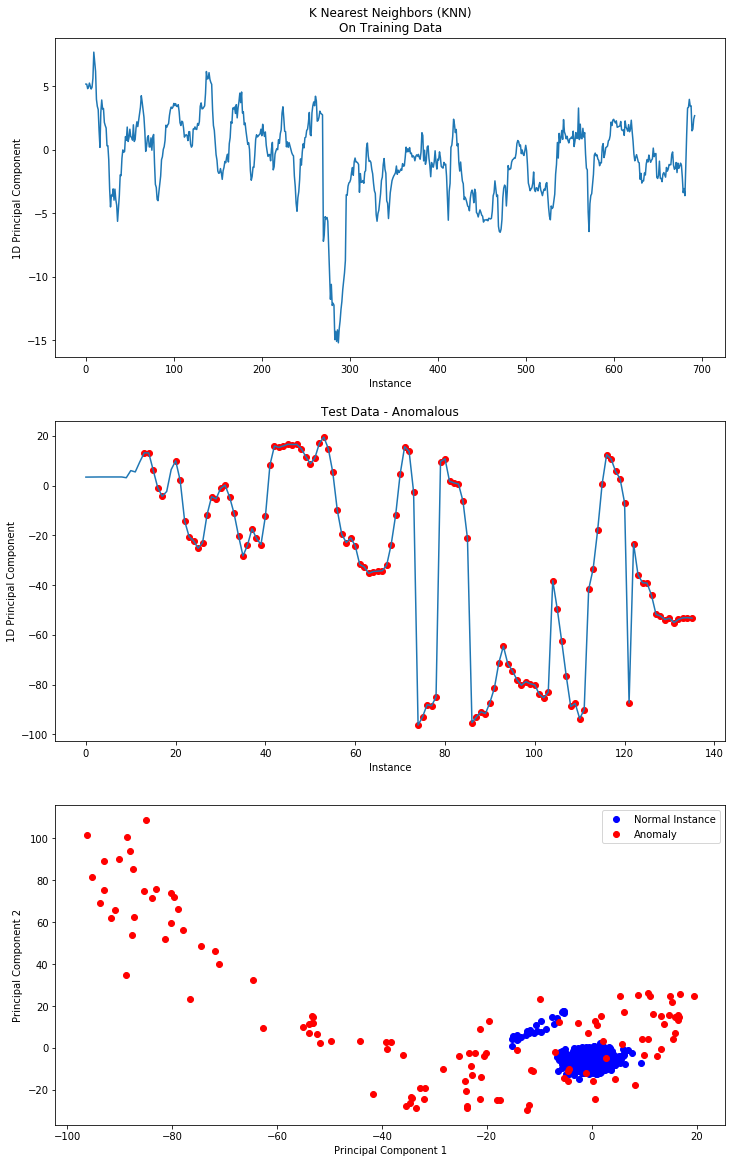

In [72]:
#using KNN
from pyod.models.knn import KNN

params = ['x','y','z','w','x.1','y.1','z.1','x.2','y.2','z.2']
#fit model

lof = KNN(n_neighbors=67,method='mean')

lof.fit(find_theta_score(trainData, pcamod))

scores = lof.decision_scores_
test_scores1 = lof.decision_function(find_theta_score(testData1,pcamod))
test_scores2 = lof.decision_function(find_theta_score(testData2,pcamod))

thres = np.mean(scores)+20*(np.std(scores))
anomalyPredictionLOF = test_scores1 > thres
anomalyPredictionLOF1 = test_scores2 > thres

plt.figure(figsize = (12,20))
ax1 = plt.subplot(3,1,1)
ax1.title.set_text('K Nearest Neighbors (KNN)\nOn Training Data')
ax1.set_xlabel('Instance')
ax1.set_ylabel('1D Principal Component')
plot_anomalies_in_1D(z_score1.T[0], anomalyPredictionLOF)
ax2 = plt.subplot(3,1,2)
ax2.title.set_text('Test Data - Anomalous')
ax2.set_xlabel('Instance')
ax2.set_ylabel('1D Principal Component')
plot_anomalies_in_1D(z_score2.T[0], anomalyPredictionLOF1)
ax3 = plt.subplot(3,1,3)
ax3.set_xlabel('Principal Component 1')
ax3.set_ylabel('Principal Component 2')
plot_anomalies_in_2D(z2_score.T, np.concatenate([anomalyPredictionLOF,anomalyPredictionLOF1]))

# LSTM Testing

In [73]:
def autoencoder_model(X):
    """
    The LSTM autoencoder model,
    returns a keras model has 5 layers
    Creates compressed representation of data, taking into 
    account data trend, and decodes it to try and reconstruct
    """
    inputs = Input(shape= (X.shape[1],X.shape[2]))
    l1 = LSTM(16, activation='relu',return_sequences=True,
             kernel_regularizer = regularizers.l2(0.00))(inputs)
    l2 = LSTM(4, activation='relu',return_sequences=False)(l1)
    l3 = RepeatVector(X.shape[1])(l2)
    l4 = LSTM(4, activation='relu',return_sequences=True)(l3)
    l5 = LSTM(16, activation='relu',return_sequences=True)(l4)
    output = TimeDistributed(Dense(X.shape[2]))(l5)
    model = Model(inputs = inputs, outputs = output)
    return model
    
aggTrainData = trainData
lstmTrain = aggTrainData.reshape(aggTrainData.shape[0],1,aggTrainData.shape[1])
lstmTest1 = testData1.reshape(testData1.shape[0],1,testData1.shape[1])
lstmTest2 = testData2.reshape(testData2.shape[0],1,testData2.shape[1])

In [74]:
model = autoencoder_model(lstmTrain)
model.compile(optimizer = 'adam', loss = 'mae')
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1, 10)             0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 1, 16)             1728      
_________________________________________________________________
lstm_10 (LSTM)               (None, 4)                 336       
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 1, 4)              0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 1, 4)              144       
_________________________________________________________________
lstm_12 (LSTM)               (None, 1, 16)             1344      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 1, 10)             170 

In [105]:
history = model.fit(lstmTrain,lstmTrain,epochs = 1000, batch_size = 30, validation_split=0.3).history

Train on 211 samples, validate on 91 samples
Epoch 1/1000
211/211 [==============================] - 0s 204us/step - loss: 0.2800 - val_loss: 0.5725
Epoch 2/1000
211/211 [==============================] - 0s 195us/step - loss: 0.2801 - val_loss: 0.5701
Epoch 3/1000
211/211 [==============================] - 0s 202us/step - loss: 0.2805 - val_loss: 0.5687
Epoch 4/1000
211/211 [==============================] - 0s 187us/step - loss: 0.2792 - val_loss: 0.5718
Epoch 5/1000
211/211 [==============================] - 0s 180us/step - loss: 0.2800 - val_loss: 0.5723
Epoch 6/1000
211/211 [==============================] - 0s 185us/step - loss: 0.2815 - val_loss: 0.5735
Epoch 7/1000
211/211 [==============================] - 0s 191us/step - loss: 0.2804 - val_loss: 0.5727
Epoch 8/1000
211/211 [==============================] - 0s 192us/step - loss: 0.2798 - val_loss: 0.5734
Epoch 9/1000
211/211 [==============================] - 0s 191us/step - loss: 0.2810 - val_loss: 0.5739
Epoch 10/1000
211/2

211/211 [==============================] - 0s 194us/step - loss: 0.2771 - val_loss: 0.5969
Epoch 79/1000
211/211 [==============================] - 0s 185us/step - loss: 0.2767 - val_loss: 0.5999
Epoch 80/1000
211/211 [==============================] - 0s 187us/step - loss: 0.2735 - val_loss: 0.5998
Epoch 81/1000
211/211 [==============================] - 0s 188us/step - loss: 0.2730 - val_loss: 0.5989
Epoch 82/1000
211/211 [==============================] - 0s 193us/step - loss: 0.2730 - val_loss: 0.5967
Epoch 83/1000
211/211 [==============================] - 0s 182us/step - loss: 0.2782 - val_loss: 0.6033
Epoch 84/1000
211/211 [==============================] - 0s 182us/step - loss: 0.2740 - val_loss: 0.6095
Epoch 85/1000
211/211 [==============================] - 0s 184us/step - loss: 0.2741 - val_loss: 0.6024
Epoch 86/1000
211/211 [==============================] - 0s 184us/step - loss: 0.2754 - val_loss: 0.6025
Epoch 87/1000
211/211 [==============================] - 0s 175us/ste

211/211 [==============================] - 0s 217us/step - loss: 0.2667 - val_loss: 0.6012
Epoch 156/1000
211/211 [==============================] - 0s 191us/step - loss: 0.2668 - val_loss: 0.6078
Epoch 157/1000
211/211 [==============================] - 0s 185us/step - loss: 0.2662 - val_loss: 0.6092
Epoch 158/1000
211/211 [==============================] - 0s 186us/step - loss: 0.2653 - val_loss: 0.6069
Epoch 159/1000
211/211 [==============================] - 0s 196us/step - loss: 0.2654 - val_loss: 0.6038
Epoch 160/1000
211/211 [==============================] - 0s 190us/step - loss: 0.2661 - val_loss: 0.6036
Epoch 161/1000
211/211 [==============================] - 0s 184us/step - loss: 0.2653 - val_loss: 0.6019
Epoch 162/1000
211/211 [==============================] - 0s 193us/step - loss: 0.2764 - val_loss: 0.6058
Epoch 163/1000
211/211 [==============================] - 0s 182us/step - loss: 0.2801 - val_loss: 0.5991
Epoch 164/1000
211/211 [==============================] - 0s 

211/211 [==============================] - 0s 205us/step - loss: 0.2668 - val_loss: 0.6063
Epoch 233/1000
211/211 [==============================] - 0s 194us/step - loss: 0.2641 - val_loss: 0.6046
Epoch 234/1000
211/211 [==============================] - 0s 194us/step - loss: 0.2634 - val_loss: 0.6044
Epoch 235/1000
211/211 [==============================] - 0s 188us/step - loss: 0.2632 - val_loss: 0.6029
Epoch 236/1000
211/211 [==============================] - 0s 190us/step - loss: 0.2659 - val_loss: 0.6045
Epoch 237/1000
211/211 [==============================] - 0s 187us/step - loss: 0.2637 - val_loss: 0.6094
Epoch 238/1000
211/211 [==============================] - 0s 195us/step - loss: 0.2628 - val_loss: 0.6065
Epoch 239/1000
211/211 [==============================] - 0s 191us/step - loss: 0.2628 - val_loss: 0.6098
Epoch 240/1000
211/211 [==============================] - 0s 189us/step - loss: 0.2642 - val_loss: 0.6096
Epoch 241/1000
211/211 [==============================] - 0s 

211/211 [==============================] - 0s 195us/step - loss: 0.2592 - val_loss: 0.6036
Epoch 310/1000
211/211 [==============================] - 0s 195us/step - loss: 0.2581 - val_loss: 0.6033
Epoch 311/1000
211/211 [==============================] - 0s 184us/step - loss: 0.2583 - val_loss: 0.6035
Epoch 312/1000
211/211 [==============================] - 0s 183us/step - loss: 0.2588 - val_loss: 0.6030
Epoch 313/1000
211/211 [==============================] - 0s 193us/step - loss: 0.2618 - val_loss: 0.6028
Epoch 314/1000
211/211 [==============================] - 0s 216us/step - loss: 0.2605 - val_loss: 0.6056
Epoch 315/1000
211/211 [==============================] - 0s 195us/step - loss: 0.2606 - val_loss: 0.6020
Epoch 316/1000
211/211 [==============================] - 0s 179us/step - loss: 0.2592 - val_loss: 0.5999
Epoch 317/1000
211/211 [==============================] - 0s 195us/step - loss: 0.2636 - val_loss: 0.6049
Epoch 318/1000
211/211 [==============================] - 0s 

211/211 [==============================] - 0s 195us/step - loss: 0.2576 - val_loss: 0.5991
Epoch 387/1000
211/211 [==============================] - 0s 185us/step - loss: 0.2572 - val_loss: 0.6001
Epoch 388/1000
211/211 [==============================] - 0s 182us/step - loss: 0.2568 - val_loss: 0.5994
Epoch 389/1000
211/211 [==============================] - 0s 183us/step - loss: 0.2665 - val_loss: 0.5990
Epoch 390/1000
211/211 [==============================] - 0s 185us/step - loss: 0.2639 - val_loss: 0.5981
Epoch 391/1000
211/211 [==============================] - 0s 178us/step - loss: 0.2611 - val_loss: 0.5955
Epoch 392/1000
211/211 [==============================] - 0s 179us/step - loss: 0.2576 - val_loss: 0.5963
Epoch 393/1000
211/211 [==============================] - ETA: 0s - loss: 0.253 - 0s 184us/step - loss: 0.2568 - val_loss: 0.5955
Epoch 394/1000
211/211 [==============================] - 0s 184us/step - loss: 0.2574 - val_loss: 0.5980
Epoch 395/1000
211/211 [=============

211/211 [==============================] - 0s 199us/step - loss: 0.2596 - val_loss: 0.5929
Epoch 464/1000
211/211 [==============================] - 0s 198us/step - loss: 0.2576 - val_loss: 0.5960
Epoch 465/1000
211/211 [==============================] - 0s 198us/step - loss: 0.2563 - val_loss: 0.5921
Epoch 466/1000
211/211 [==============================] - 0s 193us/step - loss: 0.2554 - val_loss: 0.5902
Epoch 467/1000
211/211 [==============================] - 0s 188us/step - loss: 0.2551 - val_loss: 0.5883
Epoch 468/1000
211/211 [==============================] - 0s 193us/step - loss: 0.2561 - val_loss: 0.5887
Epoch 469/1000
211/211 [==============================] - 0s 188us/step - loss: 0.2545 - val_loss: 0.5920
Epoch 470/1000
211/211 [==============================] - 0s 184us/step - loss: 0.2543 - val_loss: 0.5908
Epoch 471/1000
211/211 [==============================] - 0s 195us/step - loss: 0.2542 - val_loss: 0.5930
Epoch 472/1000
211/211 [==============================] - 0s 

211/211 [==============================] - 0s 208us/step - loss: 0.2558 - val_loss: 0.5883
Epoch 541/1000
211/211 [==============================] - 0s 190us/step - loss: 0.2538 - val_loss: 0.5855
Epoch 542/1000
211/211 [==============================] - 0s 198us/step - loss: 0.2542 - val_loss: 0.5907
Epoch 543/1000
211/211 [==============================] - 0s 183us/step - loss: 0.2534 - val_loss: 0.5916
Epoch 544/1000
211/211 [==============================] - 0s 190us/step - loss: 0.2584 - val_loss: 0.5894
Epoch 545/1000
211/211 [==============================] - 0s 183us/step - loss: 0.2570 - val_loss: 0.5869
Epoch 546/1000
211/211 [==============================] - 0s 205us/step - loss: 0.2572 - val_loss: 0.5946
Epoch 547/1000
211/211 [==============================] - 0s 212us/step - loss: 0.2559 - val_loss: 0.5954
Epoch 548/1000
211/211 [==============================] - 0s 184us/step - loss: 0.2548 - val_loss: 0.5923
Epoch 549/1000
211/211 [==============================] - 0s 

211/211 [==============================] - 0s 212us/step - loss: 0.2534 - val_loss: 0.5787
Epoch 618/1000
211/211 [==============================] - 0s 189us/step - loss: 0.2532 - val_loss: 0.5805
Epoch 619/1000
211/211 [==============================] - 0s 200us/step - loss: 0.2533 - val_loss: 0.5841
Epoch 620/1000
211/211 [==============================] - 0s 184us/step - loss: 0.2535 - val_loss: 0.5858
Epoch 621/1000
211/211 [==============================] - 0s 186us/step - loss: 0.2523 - val_loss: 0.5854
Epoch 622/1000
211/211 [==============================] - 0s 185us/step - loss: 0.2535 - val_loss: 0.5882
Epoch 623/1000
211/211 [==============================] - 0s 199us/step - loss: 0.2534 - val_loss: 0.5921
Epoch 624/1000
211/211 [==============================] - 0s 218us/step - loss: 0.2530 - val_loss: 0.5927
Epoch 625/1000
211/211 [==============================] - 0s 192us/step - loss: 0.2518 - val_loss: 0.5925
Epoch 626/1000
211/211 [==============================] - 0s 

211/211 [==============================] - 0s 180us/step - loss: 0.2506 - val_loss: 0.5819
Epoch 695/1000
211/211 [==============================] - 0s 199us/step - loss: 0.2495 - val_loss: 0.5808
Epoch 696/1000
211/211 [==============================] - 0s 208us/step - loss: 0.2495 - val_loss: 0.5789
Epoch 697/1000
211/211 [==============================] - 0s 216us/step - loss: 0.2500 - val_loss: 0.5793
Epoch 698/1000
211/211 [==============================] - 0s 201us/step - loss: 0.2510 - val_loss: 0.5757
Epoch 699/1000
211/211 [==============================] - 0s 196us/step - loss: 0.2517 - val_loss: 0.5785
Epoch 700/1000
211/211 [==============================] - 0s 180us/step - loss: 0.2500 - val_loss: 0.5789
Epoch 701/1000
211/211 [==============================] - 0s 206us/step - loss: 0.2499 - val_loss: 0.5781
Epoch 702/1000
211/211 [==============================] - 0s 178us/step - loss: 0.2512 - val_loss: 0.5756
Epoch 703/1000
211/211 [==============================] - 0s 

211/211 [==============================] - 0s 186us/step - loss: 0.2482 - val_loss: 0.5647
Epoch 772/1000
211/211 [==============================] - 0s 195us/step - loss: 0.2473 - val_loss: 0.5630
Epoch 773/1000
211/211 [==============================] - 0s 178us/step - loss: 0.2475 - val_loss: 0.5673
Epoch 774/1000
211/211 [==============================] - 0s 185us/step - loss: 0.2511 - val_loss: 0.5628
Epoch 775/1000
211/211 [==============================] - 0s 183us/step - loss: 0.2509 - val_loss: 0.5650
Epoch 776/1000
211/211 [==============================] - 0s 190us/step - loss: 0.2482 - val_loss: 0.5702
Epoch 777/1000
211/211 [==============================] - 0s 205us/step - loss: 0.2492 - val_loss: 0.5710
Epoch 778/1000
211/211 [==============================] - 0s 206us/step - loss: 0.2497 - val_loss: 0.5660
Epoch 779/1000
211/211 [==============================] - 0s 188us/step - loss: 0.2504 - val_loss: 0.5667
Epoch 780/1000
211/211 [==============================] - 0s 

211/211 [==============================] - 0s 209us/step - loss: 0.2493 - val_loss: 0.5622
Epoch 849/1000
211/211 [==============================] - 0s 185us/step - loss: 0.2496 - val_loss: 0.5561
Epoch 850/1000
211/211 [==============================] - 0s 185us/step - loss: 0.2480 - val_loss: 0.5582
Epoch 851/1000
211/211 [==============================] - 0s 187us/step - loss: 0.2461 - val_loss: 0.5617
Epoch 852/1000
211/211 [==============================] - 0s 189us/step - loss: 0.2500 - val_loss: 0.5570
Epoch 853/1000
211/211 [==============================] - 0s 187us/step - loss: 0.2488 - val_loss: 0.5577
Epoch 854/1000
211/211 [==============================] - 0s 211us/step - loss: 0.2488 - val_loss: 0.5561
Epoch 855/1000
211/211 [==============================] - 0s 212us/step - loss: 0.2488 - val_loss: 0.5524
Epoch 856/1000
211/211 [==============================] - 0s 201us/step - loss: 0.2470 - val_loss: 0.5571
Epoch 857/1000
211/211 [==============================] - 0s 

211/211 [==============================] - 0s 198us/step - loss: 0.2436 - val_loss: 0.5359
Epoch 926/1000
211/211 [==============================] - 0s 187us/step - loss: 0.2444 - val_loss: 0.5363
Epoch 927/1000
211/211 [==============================] - 0s 175us/step - loss: 0.2439 - val_loss: 0.5354
Epoch 928/1000
211/211 [==============================] - 0s 181us/step - loss: 0.2461 - val_loss: 0.5342
Epoch 929/1000
211/211 [==============================] - 0s 204us/step - loss: 0.2459 - val_loss: 0.5352
Epoch 930/1000
211/211 [==============================] - 0s 202us/step - loss: 0.2437 - val_loss: 0.5396
Epoch 931/1000
211/211 [==============================] - 0s 185us/step - loss: 0.2461 - val_loss: 0.5367
Epoch 932/1000
211/211 [==============================] - 0s 197us/step - loss: 0.2453 - val_loss: 0.5331
Epoch 933/1000
211/211 [==============================] - 0s 182us/step - loss: 0.2527 - val_loss: 0.5364
Epoch 934/1000
211/211 [==============================] - 0s 

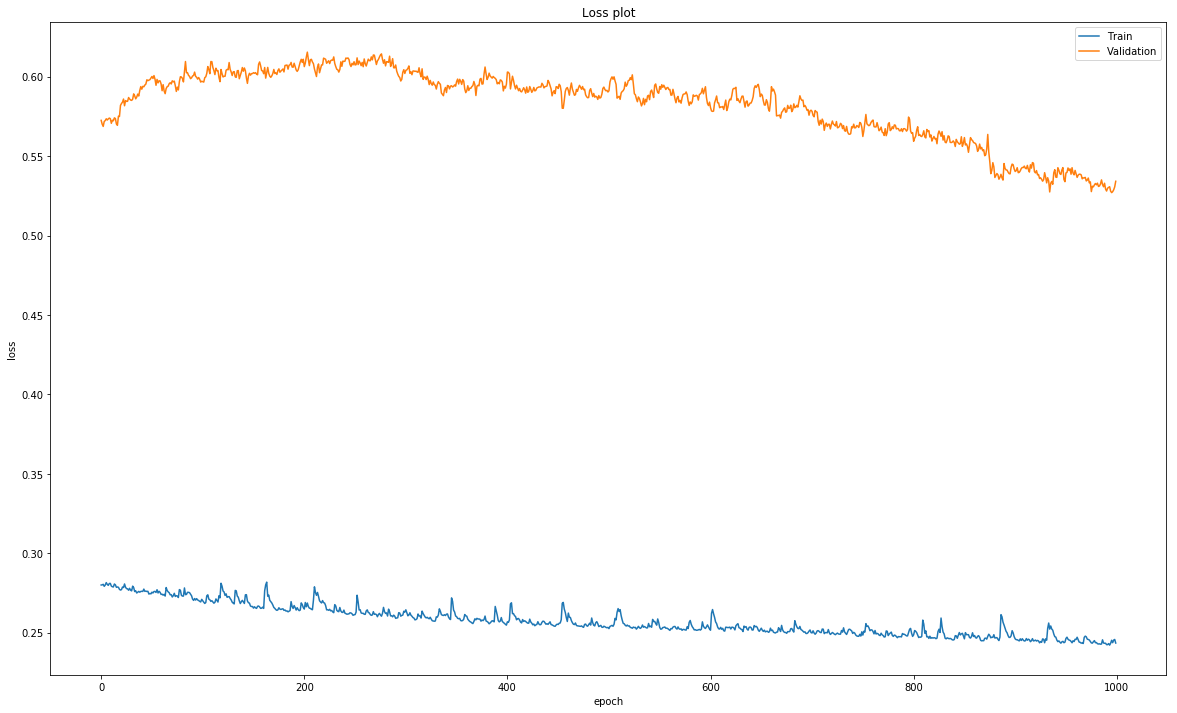

In [106]:
fig, ax = plt.subplots(figsize = (20,12))
ax.plot(history['loss'],label='Train')
ax.plot(history['val_loss'],label='Validation')
ax.set_title('Loss plot')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend()
plt.show()


In [55]:
"""lstmPred = model.predict(lstmTrain)
lstmPred = lstmPred.reshape(lstmPred.shape[0],lstmPred.shape[2])
lstmTrain = lstmTrain.reshape(lstmTrain.shape[0],lstmTrain.shape[2])
scores = np.mean(np.abs(lstmPred-lstmTrain),axis = 1)
plt.hist(scores)
plt.title('Loss Distribution')"""

"lstmPred = model.predict(lstmTrain)\nlstmPred = lstmPred.reshape(lstmPred.shape[0],lstmPred.shape[2])\nlstmTrain = lstmTrain.reshape(lstmTrain.shape[0],lstmTrain.shape[2])\nscores = np.mean(np.abs(lstmPred-lstmTrain),axis = 1)\nplt.hist(scores)\nplt.title('Loss Distribution')"

In [122]:
thres = scores.mean()+6*scores.std()

In [123]:
lstmPred1 = model.predict(lstmTest1)
lstmPred2 = model.predict(lstmTest2)

lstmPred1 = lstmPred1.reshape(lstmPred1.shape[0],lstmPred1.shape[2])
lstmPred2 = lstmPred2.reshape(lstmPred2.shape[0],lstmPred2.shape[2])

testScores1 = np.mean(np.abs(lstmPred1-testData1),axis=1)
testScores2 = np.mean(np.abs(lstmPred2-testData2),axis=1)

In [124]:
anomalyPredictionLSTM1 = testScores1>thres
anomalyPredictionLSTM2 = testScores2>thres

In [125]:
#left blank intentionally

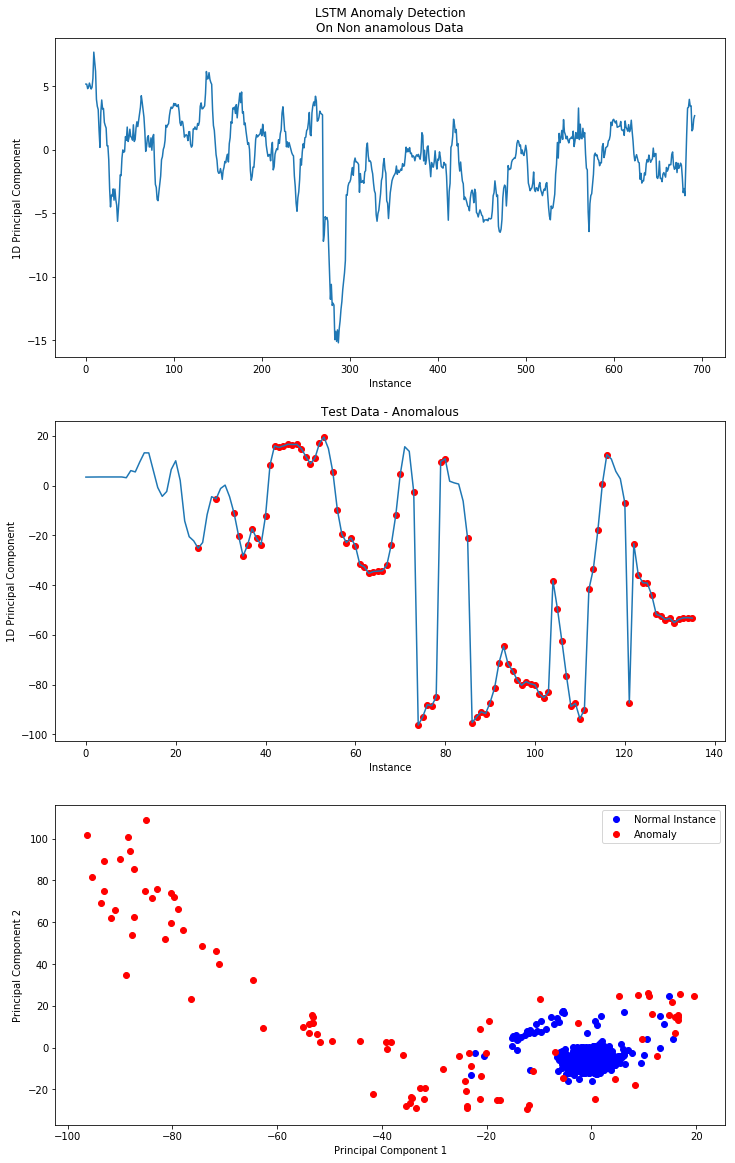

In [126]:
plt.figure(figsize = (12,20))
ax1 = plt.subplot(3,1,1)
ax1.title.set_text('LSTM Anomaly Detection\nOn Non anamolous Data')
ax1.set_xlabel('Instance')
ax1.set_ylabel('1D Principal Component')
plot_anomalies_in_1D(z_score1.T[0], anomalyPredictionLSTM1)
ax2 = plt.subplot(3,1,2)
ax2.title.set_text('Test Data - Anomalous')
ax2.set_xlabel('Instance')
ax2.set_ylabel('1D Principal Component')
plot_anomalies_in_1D(z_score2.T[0], anomalyPredictionLSTM2)
ax3 = plt.subplot(3,1,3)
ax3.set_xlabel('Principal Component 1')
ax3.set_ylabel('Principal Component 2')
plot_anomalies_in_2D(z2_score.T, np.concatenate([anomalyPredictionLSTM1,anomalyPredictionLSTM2]))